# Basic Reinforcement Learning 

Simple examples of RL using Tensorflow and OpenAI gym

## Create `cartpole` environment

In [1]:
import gym

In [2]:
env = gym.make('CartPole-v0')

[2016-11-01 14:17:07,474] Making new env: CartPole-v0


Check action and observation spaces dimensions

In [3]:
env.action_space, env.observation_space

(Discrete(2), Box(4,))

Check observation space boundaries

In [4]:
list(zip(env.observation_space.low, env.observation_space.high))

[(-4.7999999999999998, 4.7999999999999998),
 (-3.4028234663852886e+38, 3.4028234663852886e+38),
 (-0.41887902047863906, 0.41887902047863906),
 (-3.4028234663852886e+38, 3.4028234663852886e+38)]

I would guess the dimensions are:

* cart's horizontal position
* cart's speed along horizontal position
* pole's angle
* pole's angular speed

## The random guessing algorithm

We will use linear regression model to find the optimal policy (actions) given observation states. We will perform random search to find the best parameters.

In [5]:
import numpy as np
from tqdm import tqdm

In [6]:
N_MODELS = 10000 # models to try
MAX_STEPS = 200  # steps per episodes

Because the action space is discrete, we only need to take the sign of the linear regression output. In this case the weights can be sampled uniformly in [-1, 1]. However, if we want to use the bias term, it should be sampled according to the boundaries of the observation space (?)

In [7]:
# generate model weights: [n_models, n_params]
models = 2 * np.random.random([N_MODELS, env.observation_space.shape[0]]) - 1 # uniform in [-1, +1]

In [8]:
class LinearAgent(object):
    def __init__(self, weights=None):
        self._weights = weights
        
    @property
    def weights(self):
        return self._weights

    @weights.setter
    def weights(self, new_weights):
        self._weights = new_weights
        
    def action(self, state):
        a = np.dot(self._weights, state)
        return int(a > 0)

In [9]:
def play_episode(env, agent, max_steps=MAX_STEPS):
    observations = []
    rewards = []
    o = env.reset()
    for t in range(max_steps):
        a = agent.action(o)
        o, r, done, info = env.step(a)
        rewards.append(r)
        observations.append(o)
        if done:
            break
    return observations, rewards

In [10]:
def evaluate_agent(env, agent, n_experiments=20, max_steps=MAX_STEPS):
    episode_rewards = []
    for e in range(n_experiments):
        observations, rewards = play_episode(env, agent, max_steps)
        
        avg_reward = np.array(rewards).sum() / max_steps
        episode_rewards.append(avg_reward)
    
    episode_rewards = np.array(episode_rewards)
    return episode_rewards.sum(), episode_rewards.mean()

In [11]:
model_metrics = np.zeros((models.shape[0], 2)) # total and mean reward for each model
for i, m in tqdm(enumerate(models)):
    agent = LinearAgent(m)
    model_metrics[i, :] = evaluate_agent(env, agent)

10000it [01:23, 120.30it/s]


In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

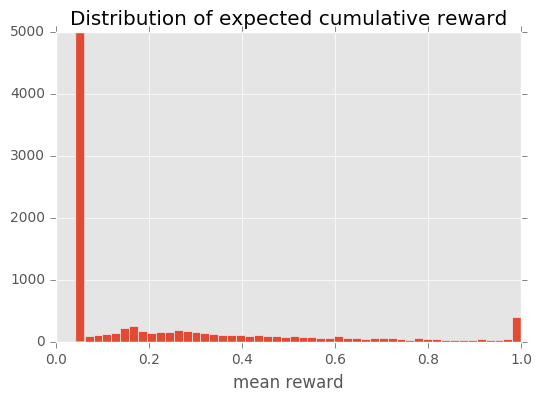

In [13]:
plt.hist(model_metrics[:,1], bins=50)
plt.title('Distribution of expected cumulative reward')
plt.xlabel('mean reward')
plt.show()

In [14]:
print('% of successful models', (model_metrics[:,1] == 1.0).mean())

% of successful models 0.0327


## Visualize the observation space

Sample observations using random policies

In [15]:
observations = []
for m_id in np.random.randint(0, models.shape[0], size=200):
    agent = LinearAgent(models[m_id])
    os, rs = play_episode(env, agent)
    observations.extend(os)
    
observations = np.array(observations)

assign actions to each observation using the best performing model

In [16]:
# pick the best model
m_id = model_metrics.argmax(axis=0)[1]
weights = models[m_id]

In [17]:
# assign actions
actions = np.dot(observations, weights)
actions = (actions > 0).astype(int)

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=0)
observations_pca = pca.fit_transform(observations)

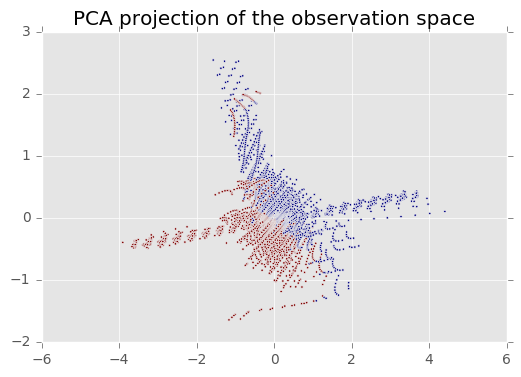

In [19]:
plt.scatter(observations_pca[:,0], observations_pca[:,1], s=3, c=actions)
plt.title('PCA projection of the observation space')
plt.show()

## The hill-climbing algorithm

In [20]:
n_experiments = 500
noise_scale = 1.0
experiment_steps = np.zeros(n_experiments)
for i in tqdm(range(n_experiments)):
    old_weights = 2 * np.random.random(env.observation_space.shape) - 1 # uniform in [-1, +1]
    agent = LinearAgent()
    r_best = 0.0
    for step in range(MAX_STEPS):
        noise = np.random.randn(*old_weights.shape)
        new_weights = old_weights + noise_scale * noise
        
        agent.weights = new_weights
        r_total, r_mean = evaluate_agent(env, agent)
        if r_mean == 1.0:
            experiment_steps[i] = step + 1
            break
        if r_mean > r_best:
            r_best = r_mean
            old_weights = new_weights

100%|██████████| 500/500 [02:34<00:00,  3.10it/s]


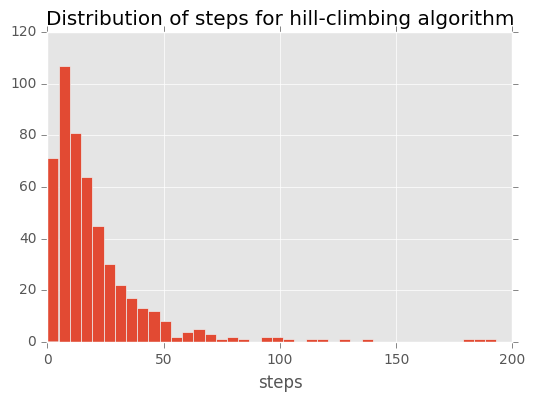

In [21]:
plt.hist(experiment_steps, bins=40)
plt.title('Distribution of steps for hill-climbing algorithm')
plt.xlabel('steps')
plt.show()

'0' bin means the algorithm did not converge

## Policy gradient algorithm

In [22]:
import tensorflow as tf

In [23]:
tf.reset_default_graph()

In [24]:
n_state_dims = env.observation_space.shape[0]
n_action_dims = env.action_space.n
n_state_dims, n_action_dims

(4, 2)

build graph

In [25]:
with tf.name_scope('policy'):
    states_in = tf.placeholder(tf.float32, [None, n_state_dims], name='states')
    W = tf.Variable(tf.truncated_normal([n_state_dims, n_action_dims], stddev=0.1), name='W')
    # b = tf.Variable(tf.constant(0.0, shape=[n_action_dims]), name='b')
    
    logits = tf.matmul(states_in, W)
    probs = tf.nn.softmax(logits, name='probabilities')

In [26]:
with tf.name_scope('policy_gradient'):
    actions_in = tf.placeholder(tf.int32, [None], name='actions')
    rewards_in = tf.placeholder(tf.float32, [None], name='cumulative_rewards')
    
    actions_one_hot = tf.one_hot(actions_in, n_action_dims)
    entropies = tf.nn.softmax_cross_entropy_with_logits(logits, actions_one_hot)
    weighted_entropies = tf.mul(entropies, rewards_in)
    loss = tf.reduce_sum(weighted_entropies, name='loss')

In [27]:
with tf.name_scope('optimizer'):
    global_step = tf.Variable(0, name='global_step', trainable=False)
    train_op = tf.train.AdamOptimizer(0.003).minimize(loss, global_step=global_step)

create session

In [28]:
init_op = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init_op)

In [29]:
def policy(state):
    "Return sampled action given state"
    a_probs = sess.run(probs, feed_dict={states_in: [state]})[0]
    a = np.random.choice(2, p=a_probs)
    return a

def policy_grad_descent(states, actions, cumulative_rewards):
    "Run single gradient update and return loss"
    feed_dict = {states_in: states, actions_in: actions, rewards_in: cumulative_rewards}
    _, loss_val = sess.run([train_op, loss], feed_dict=feed_dict)
    return loss_val

In [30]:
def play_policy(env, policy, n_trajectories=20, n_steps=MAX_STEPS):
    "Generate trajectories given policy"
    trajectories = []
    for i in range(n_trajectories):
        s = env.reset()
        trajectory = []
        for step in range(n_steps):
            a = policy(s)
            new_s, r, done, info = env.step(a)
            trajectory.append([s, a, r])
            if done:
                break
            s = new_s
        trajectories.append(trajectory)
    return trajectories

In [31]:
def calc_cumulative_rewards(rewards, gamma=0.99):
    """Given rewards at each step calculate 
    discounted cumulative future reward for each step"""
    cumulative_rewards = np.zeros_like(rewards)
    discounts = np.power(gamma, np.arange(len(rewards)))
    for l in range(len(rewards)):
        future_rewards = rewards[l:]
        discounted = (future_rewards * discounts[:len(future_rewards)])
        cumulative_rewards[l] = discounted.sum()
    return cumulative_rewards

def update_policy(trajectories, policy_grad_descent, n_steps=MAX_STEPS):
    "Run policy gradient descent on each trajectory"
    losses = []
    total_rewards = []
    for trajectory in trajectories:
        states, actions, rewards = zip(*trajectory)
        cumulative_rewards = calc_cumulative_rewards(rewards)
        loss = policy_grad_descent(states, actions, cumulative_rewards)
        losses.append(loss / n_steps)
        total_reward = np.sum(rewards) / n_steps
        total_rewards.append(total_reward)
    return np.mean(losses), np.mean(total_rewards)

In [32]:
n_epochs = 100
avg_losses = []
avg_rewards = []
for _ in tqdm(range(n_epochs)):
    trajectories = play_policy(env, policy)
    avg_loss, avg_reward = update_policy(trajectories, policy_grad_descent)
    avg_losses.append(avg_loss)
    avg_rewards.append(avg_reward)
    if avg_reward == 1.0:
        print('early stopping')
        break

 97%|█████████▋| 97/100 [00:48<00:02,  1.31it/s]

early stopping


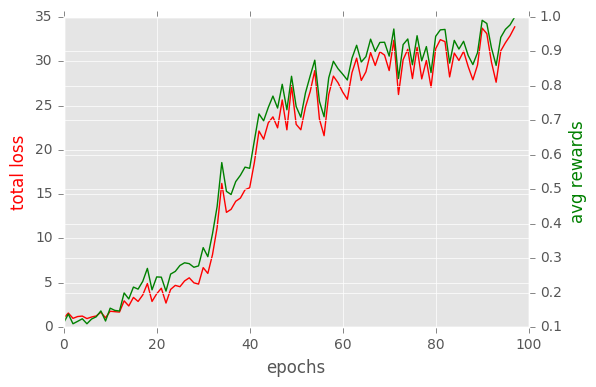

In [33]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(avg_losses, 'r')
ax2.plot(avg_rewards, 'g')

ax1.set_xlabel('epochs')
ax1.set_ylabel('total loss', color='r')
ax2.set_ylabel('avg rewards', color='g')

plt.show()

As the policy gets better trajectories get longer. That's why the total loss increases overtime, despite the objective which is to minimize it